In [4]:
import numpy as np
import pandas as pd
import os
from pymol import cmd
import glob

import seaborn as sns
import matplotlib.pyplot as plt

from src.SupertypeTools import CalcMat, CGCalcMat, dist_heatmap, SSE, hierarchical_cluster
# from src.CGmodel import CG_RMSD

# from BindingGrooveParameterization import PDB_preprocess
# from PointCloud import PDB_to_csv, PointCloudCG, CGDAT_dir_reweight
# contact = [7,9,24,45,59,62,63,66,67,69,70,73,74,76,77,80,81,84,95,97,99,114,116,118,143,147,150,152,156,158,159,163,167,171] #netMHCpan
# weight = {5:[7,9,24,45,62,63,66,67,70,74,77,80,81,84,95,97,99,116,118,143,147,159]} #arbitrary

#Hanneke W.M. van Deutekom and Can Kesmir 2015
# contact = [7,9,24,45,59,63,66,67,69,70,74,76,77,80,95,97,99,114,116,152,156,158,163,167,171]
# weight = {9.9:[63],7.6:[67],5.8:[116],5.4:[9],4.7:[97],4.6:[152],3.8:[167],3.7:[156],3.6:[74],3.2:[70],3:[80],2.9:[171],2.8:[45],2.7:[66],2.7:[77],2.4:[76],2.3:[114],2.1:[99],1.5:[163],1.5:[95],1.4:[59],1.4:[158],1.2:[69],1.2:[24],1:[7]}

In [5]:
# seq = 'GSHSMRYFHTSVSRPGRGEPRFITVGYVDDTLFVRFDSDAASPREEPRAPWIEQEGPEYWDRETQICKAKAQTDREDLRTLLRYYNQSEAGSHTLQNMYGCDVGPDGRLLRGYHQHAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRAYLEGECVEWLRRYLENGKETLQRADPPKTHVTHHPISDHEATLRCWALGFYPAEITLTWQRDGEDQTQDTELVETRPAGDRTFQKWAAVVVPSGEEQRYTCHVQHEGLPKPLTLRWEPSSQSTVPIVGIVAGLAVLAVVVIGAVVAAVMCRRKSSGGKGGSYSQAACSDSAQGSDVSLTA'

# ''.join([seq[loc-1] for loc in contact])

# process pdb files
# PDB_preprocess("../HLA1_models/CF_relaxed/PDB", "1i4f_Crown.pdb", "../HLA1_models/CF_relaxed/TRIM", "../HLA1_models/CF_relaxed/ALIGN", "HLA1_CF_relaxed_trim.csv")

# PDB_to_csv("../HLA1_models/CF_relaxed/ALIGN", "../HLA1_models/CF_relaxed/DAT")
# PointCloudCG("../HLA1_models/CF_relaxed/DAT", "../HLA1_models/CF_relaxed/CG_DAT")
# PDB_to_csv("../crystal/Class1/ALIGN", "../crystal/Class1/DAT")
# PointCloudCG("../crystal/Class1/DAT", "../crystal/Class1/CG_DAT")

# weight = {"A":{63:9.9,67:7.6,116:5.8,9:5.4,97:4.7,152:4.6,167:3.8,156:3.7,74:3.6,70:3.2,80:3.0,171:2.9,45:2.8,77:2.7,76:2.4,114:2.3,99:2.1,95:1.5,158:1.4,24:1.2,7:1.0}}
# CGDAT_dir_reweight("../HLA1_models/CF_relaxed/CG_DAT", weight)
# CGDAT_dir_reweight("../crystal/Class1/CG_DAT", weight)

### Figure 1 kernel curve

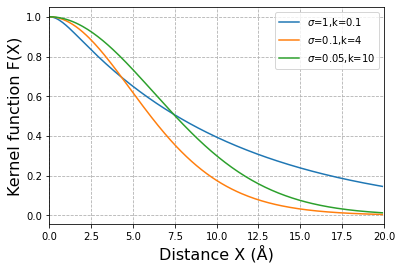

In [5]:
w_list = [0.1, 4, 10]
sigma_list = [1, 0.1, 0.05]
x = np.arange(0,20,0.1)

# y = np.reciprocal(np.cosh(0.1*x))**4 # param used in paper

for w, sigma in zip(w_list, sigma_list):
    y3 = np.reciprocal(np.cosh(sigma*x))**w
    plt.plot(x,y3, label=f"$\sigma$={sigma},k={w}")
plt.xlabel("Distance X (Å)", fontsize=16)
plt.ylabel("Kernel function F(X)",fontsize=16)
plt.xlim([0,20])
plt.grid(linestyle='--')
plt.legend()
plt.savefig('kernel.png', dpi=300)
plt.show()

# w
# for w in w_list:
#     y1 = np.reciprocal(np.cosh(0.1*x))**w
#     plt.plot(x,y1)
# plt.plot(x,y)
# plt.show()

# # sigma
# for sigma in sigma_list:
#     y2 = np.reciprocal(np.cosh(sigma*x))**4
#     plt.plot(x,y2)
# plt.plot(x,y)
# plt.show()

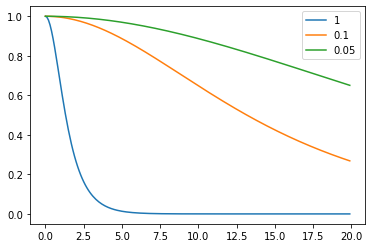

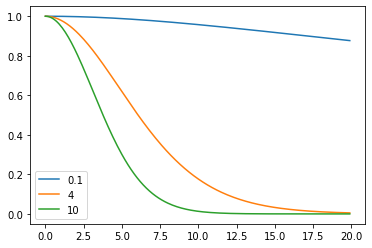

In [6]:
for sigma in sigma_list:
    y2 = np.reciprocal(np.cosh(sigma*x))**1
    plt.plot(x,y2,label=sigma)

plt.legend()
plt.show()

for w in w_list:
    y1 = np.reciprocal(np.cosh(0.1*x))**w
    plt.plot(x,y1,label=w)
plt.legend()
plt.show()

### Figure 1 function and parameters

In [7]:
centroids = {"A01_01":"4NQX","A02_01":"3H7B","A02_03":"3OX8","A02_06":"3OXR",
        "A02_07":"3OXS","A03_01":"3RL2","A11_01":"6JOZ","A24_02":"4F7M",
        "A30_01":"6J1W","A30_03":"6J29","A68_01":"6PBH","B07_02":"5EO1",
        "B08_01":"4QRS","B14_02":"3BVN","B15_01":"3C9N","B18_01":"6MT3",
        "B27_03":"6PZ5","B27_04":"5DEF","B27_05":"3B6S","B27_06":"5DEG",
        "B27_09":"3HCV","B35_01":"1ZSD","B37_01":"6MT4","B39_01":"4O2E",
        "B40_01":"6IEX","B40_02":"5IEK","B42_01":"4U1M","B44_02":"3L3I",
        "B44_03":"1N2R","B46_01":"4LCY","B51_01":"4MJI","B57_01":"6D2B",
        "B58_01":"5IND","C03_04":"1EFX","C04_01":"1IM9","C05_01":"6JTO",
        "C06_02":"5W69","C08_01":"4NT6","C08_02":"6JTP"}

A_list = ["A01_01","A02_01","A02_03","A02_06","A02_07","A03_01","A11_01","A24_02","A30_01","A30_03","A68_01"]
B_list = ["B07_02","B08_01","B14_02","B15_01","B18_01","B27_03","B27_04","B27_05","B27_06","B27_09","B35_01",
        "B37_01","B39_01","B40_01","B40_02","B42_01","B44_02","B44_03","B46_01","B51_01","B57_01","B58_01"]
C_list = ["C03_04","C04_01","C05_01","C06_02","C08_01","C08_02"]

In [8]:
def Calculate_RMSD(InPDB, refPDB):
    cmd.load(refPDB, "template")
    cmd.load(InPDB, "target")

    FA_RMSD = cmd.align(f"target", f"template", cycles=0, transform=0)[0] # full-atom RMSD
    BB_RMSD = cmd.align(f"target////CA", f"template////CA", cycles=0, transform=0)[0] # back-bone RMSD

    cmd.delete("target")
    cmd.delete("template")

    return FA_RMSD, BB_RMSD

def Calculate_CG_RMSD(InDAT, RefDAT):
    """
    RMSD of coarse-grained representations assumes that residues are one-by-one aligned
    """
    in_df = pd.read_csv(InDAT)
    ref_df = pd.read_csv(RefDAT)
    non_missing_res = in_df['X'].notna() # filter out residues missing side chain
    in_coord = in_df.loc[non_missing_res,['X', 'Y', 'Z']].values
    ref_coord = ref_df.loc[non_missing_res,['X', 'Y', 'Z']].values

    RMSD = np.sqrt(np.linalg.norm(in_coord-ref_coord)**2/len(in_df))
    return RMSD

def RMSD_plot(Crystal_data, Model_data, weight1, weight2, label1, label2):
    plt.figure(figsize=(8,6))
    plt.hist(Crystal_data, weights=weight1, range=(0.0, 2.2), bins=21, histtype='step', linewidth=2, ec=(1, 0.6, 0, 1), label=label1, fill=True, fc=(1, 0.6, 0, 0.3))
    plt.hist(Model_data, weights=weight2, range=(0.0, 2.2), bins=21, histtype='step', linewidth=2, ec=(0, 0.6, 1, 1), label=label2, fill=True, fc=(0, 0.6, 1, 0.3))
    # (0, 0.6, 1, 1)
    plt.xlim((0.0, 2.2))
    plt.ylim((0, 0.4))
    plt.xlabel("RMSD (Å)", fontsize=16)
    plt.tick_params('x', labelsize=14)
    plt.tick_params('y', labelsize=14)
    plt.ylabel("probability", fontsize=16)
    plt.legend(fontsize=16)
    plt.show()

    return

### === Figure 1 ===

Full-atom


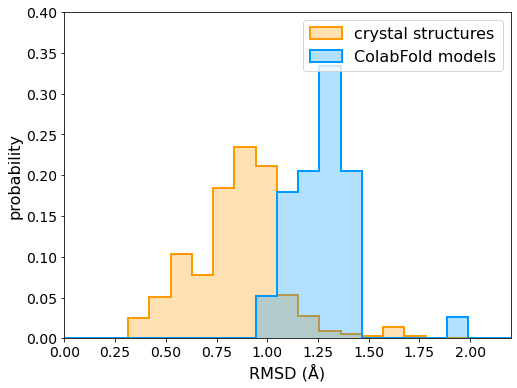

Back-Bone


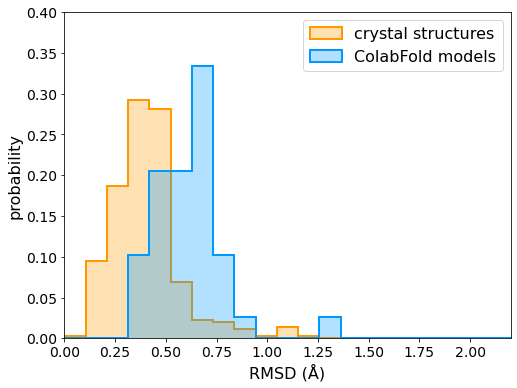

Coarse-grained


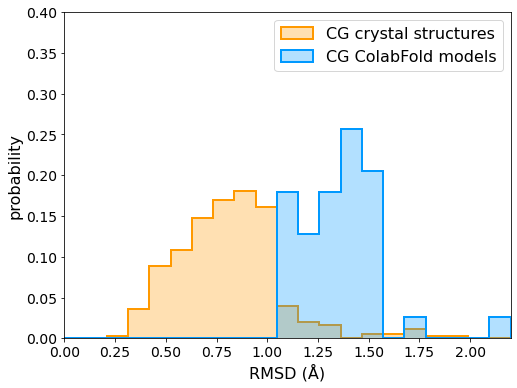

In [10]:
Model_dir = "HLA1_models"
Crystal_dir = "crystal/Class1"

Crystal_FA_rmsd = []
Crystal_BB_rmsd = []
Crystal_CG_rmsd = []

Model_FA_rmsd = []
Model_BB_rmsd = []
Model_CG_rmsd = []

for allele in A_list+B_list+C_list:
    Model_structure = f"{Model_dir}/ALIGN/{allele}.pdb"
    Crystal_structures = glob.glob(f"{Crystal_dir}/ALIGN/{allele}_*.pdb")
    Centroid_structure = f"{Crystal_dir}/ALIGN/{allele}_{centroids[allele]}.pdb"
    Crystal_structures.remove(Centroid_structure)
    
    Model_CG = f"{Model_dir}/CG_DAT/{allele}.csv"
    Crystal_CG = glob.glob(f"{Crystal_dir}/CG_DAT/{allele}_*.csv")
    Centroid_CG = f"{Crystal_dir}/CG_DAT/{allele}_{centroids[allele]}.csv"
    Crystal_CG.remove(Centroid_CG)

    for structure in Crystal_structures:
        FA_RMSD, BB_RMSD = Calculate_RMSD(structure, Centroid_structure)
        Crystal_FA_rmsd.append(FA_RMSD)
        Crystal_BB_rmsd.append(BB_RMSD)

    for structure_CG in Crystal_CG:
        CG_RMSD = Calculate_CG_RMSD(structure_CG, Centroid_CG)
        Crystal_CG_rmsd.append(CG_RMSD)


    mFA_RMSD, mBB_RMSD = Calculate_RMSD(Model_structure, Centroid_structure)
    Model_FA_rmsd.append(mFA_RMSD)
    Model_BB_rmsd.append(mBB_RMSD)

    mCG_RMSD = Calculate_CG_RMSD(Model_CG, Centroid_CG)
    Model_CG_rmsd.append(mCG_RMSD)

weights1 = np.ones_like(Crystal_FA_rmsd)/float(len(Crystal_FA_rmsd))
weights2 = np.ones_like(Model_FA_rmsd)/float(len(Model_FA_rmsd))

# ========== Full atom RMSD ============
print("Full-atom")
RMSD_plot(Crystal_FA_rmsd, Model_FA_rmsd, weights1, weights2, label1="crystal structures", label2="ColabFold models")

# =========== Back bone RMSD =============
print("Back-Bone")
RMSD_plot(Crystal_BB_rmsd, Model_BB_rmsd, weights1, weights2, label1="crystal structures", label2="ColabFold models")

# =========== Coarse grained RMSD ===========
print("Coarse-grained")
RMSD_plot(Crystal_CG_rmsd, Model_CG_rmsd, weights1, weights2, label1="CG crystal structures", label2="CG ColabFold models")

In [15]:
np.mean(Crystal_CG_rmsd)

0.8150531096286057

### === Figure 3: clustering of homology model, representive crystal structure, and mean crystal structure ===

In [11]:
# import shutil
# for allele in A_list+B_list+C_list:
#     shutil.copy2(f"../HLA1_models/CF_unrelaxed/CG_DAT/{allele}.csv", f"../Figures/Figure2_clustering_cr_hm/CG_DAT/{allele}_rosetta.csv")

#### dendrogram of crystal structures

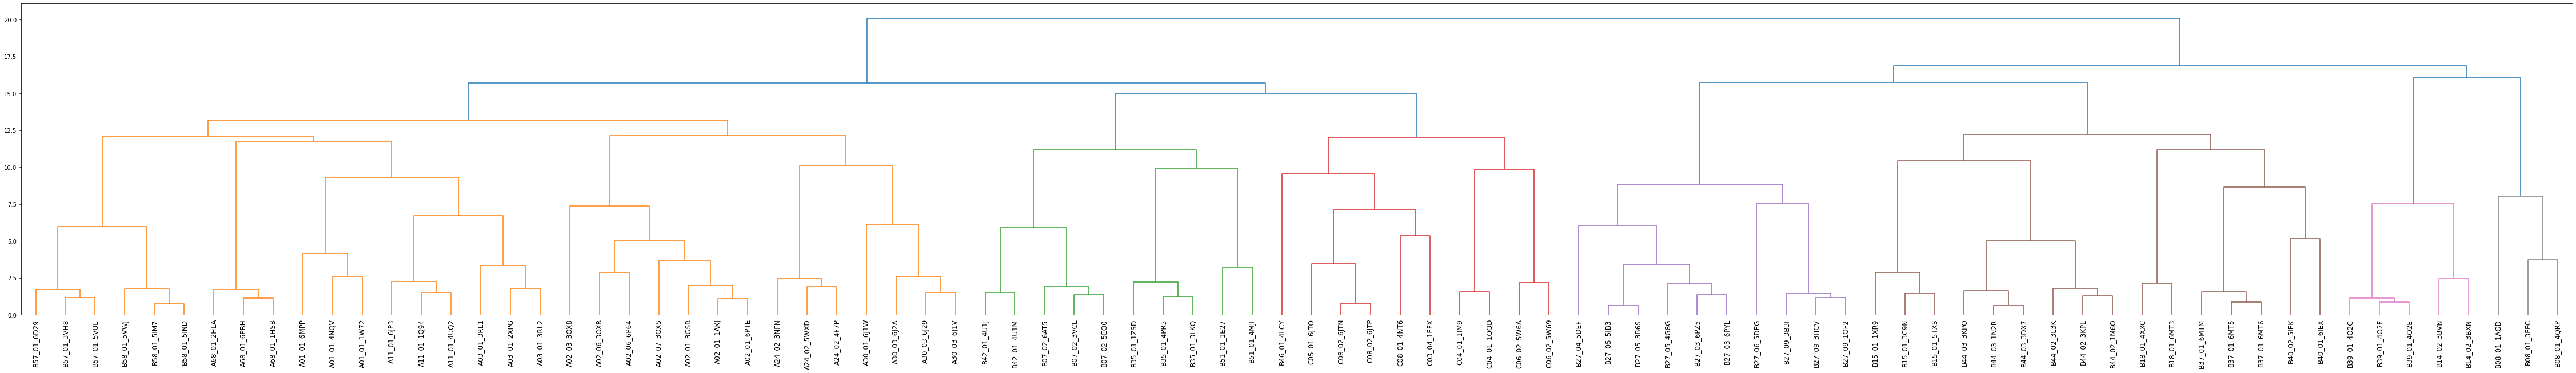

In [16]:
Mat = CGCalcMat("../Figures/Figure2_clustering_cr_hm/CG_DAT", "../Figures/Figure2_clustering_cr_hm/cr.list", sigma=0.1, w=4)
_ = hierarchical_cluster(Mat, N=None, L='complete', threshold=1, plot_dendro=True, outtree="Fig2_crystal_only.newick")

#### relaxed colabfold models

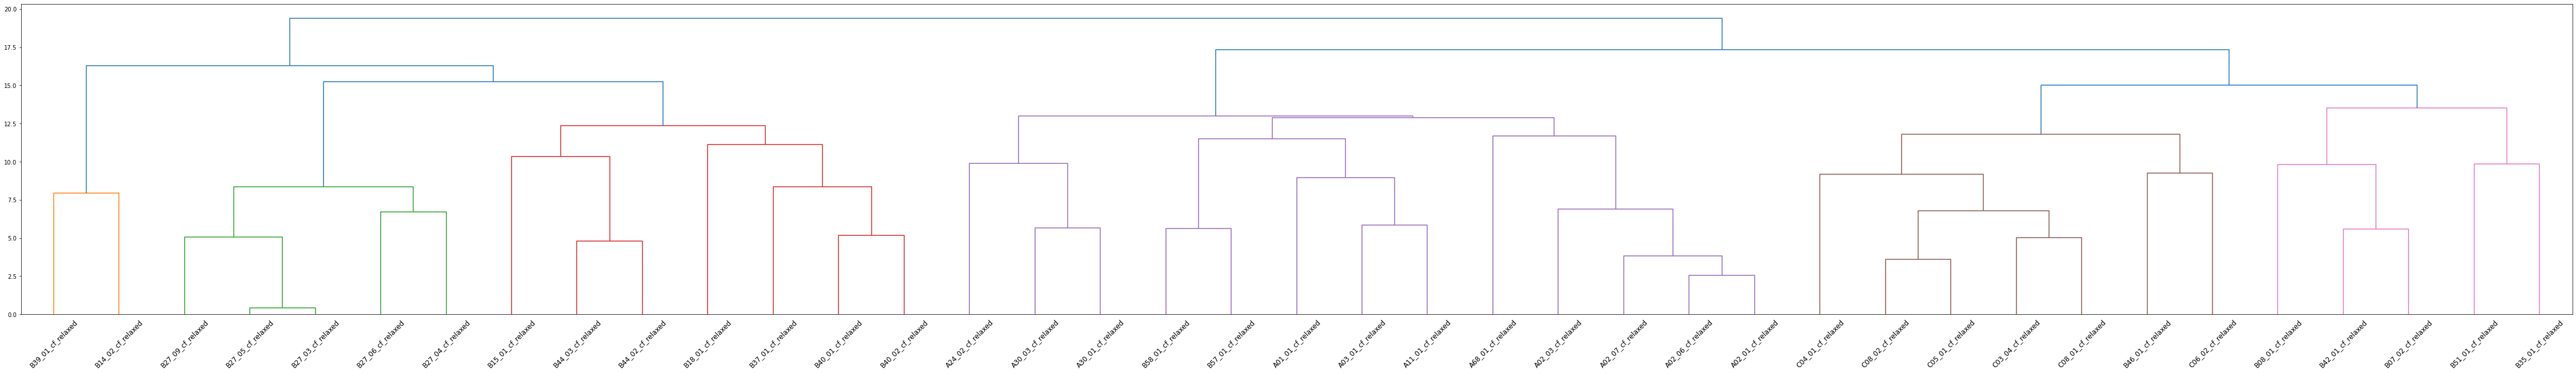

In [17]:
Mat = CGCalcMat("../Figures/Figure2_clustering_cr_hm/CG_DAT", "../Figures/Figure2_clustering_cr_hm/cf_relaxed_only.list", sigma=0.1, w=4)
_ = hierarchical_cluster(Mat, N=None, L='complete', threshold=1, plot_dendro=True, outtree="Fig2_cf_relaxed_only.newick")

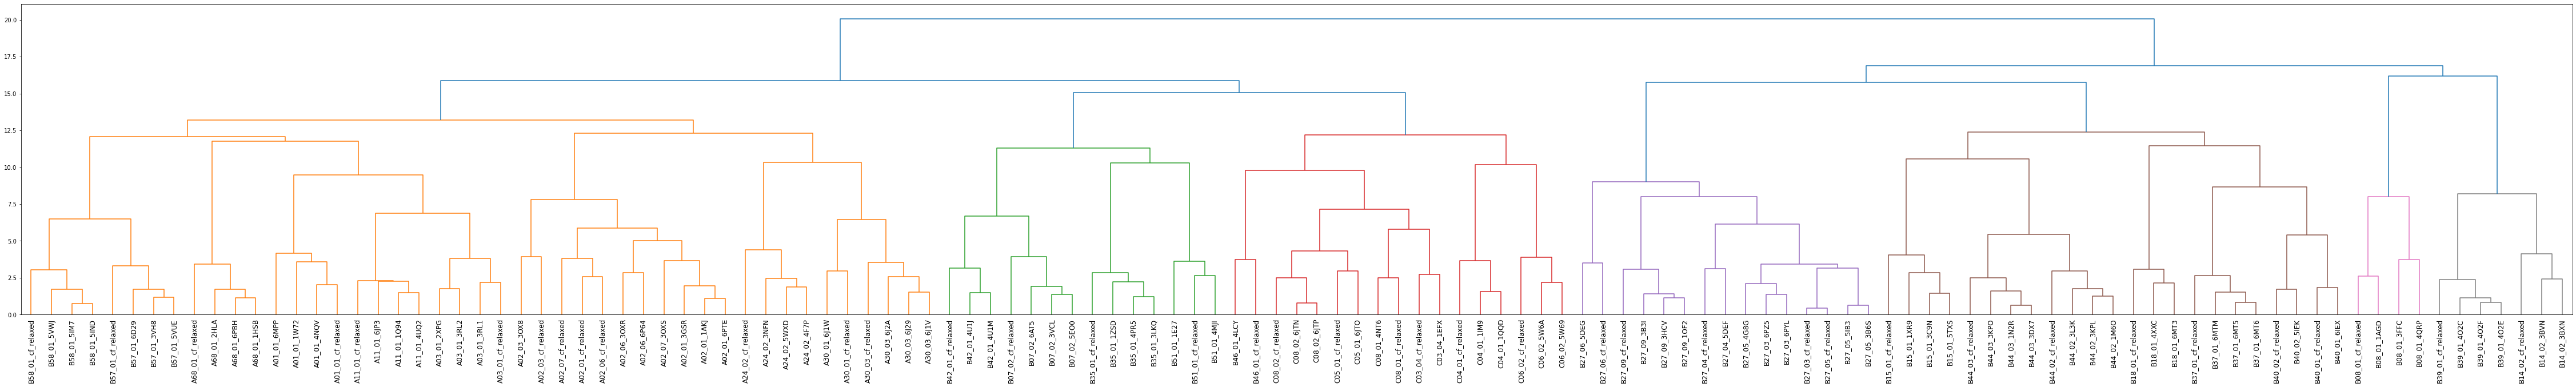

In [18]:
Mat = CGCalcMat("../Figures/Figure2_clustering_cr_hm/CG_DAT", "../Figures/Figure2_clustering_cr_hm/cf_relaxed.list", sigma=0.1, w=4)
_ = hierarchical_cluster(Mat, N=None, L='complete', threshold=1, plot_dendro=True, outtree="Fig2_cf_relaxed.newick")

#### unrelaxed colabfold models

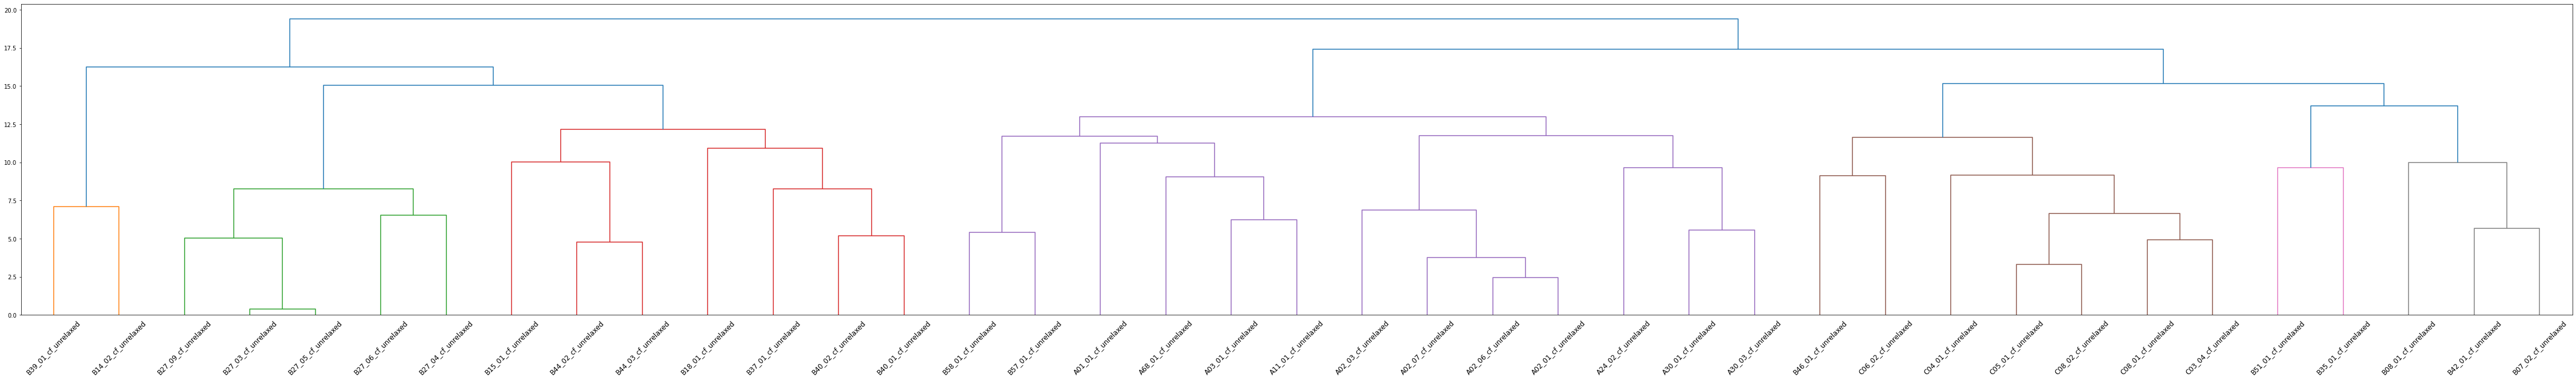

In [19]:
Mat = CGCalcMat("../Figures/Figure2_clustering_cr_hm/CG_DAT", "../Figures/Figure2_clustering_cr_hm/cf_unrelaxed_only.list", sigma=0.1, w=4)
_ = hierarchical_cluster(Mat, N=None, L='complete', threshold=1, plot_dendro=True, outtree="Fig2_cf_unrelaxed_only.newick")

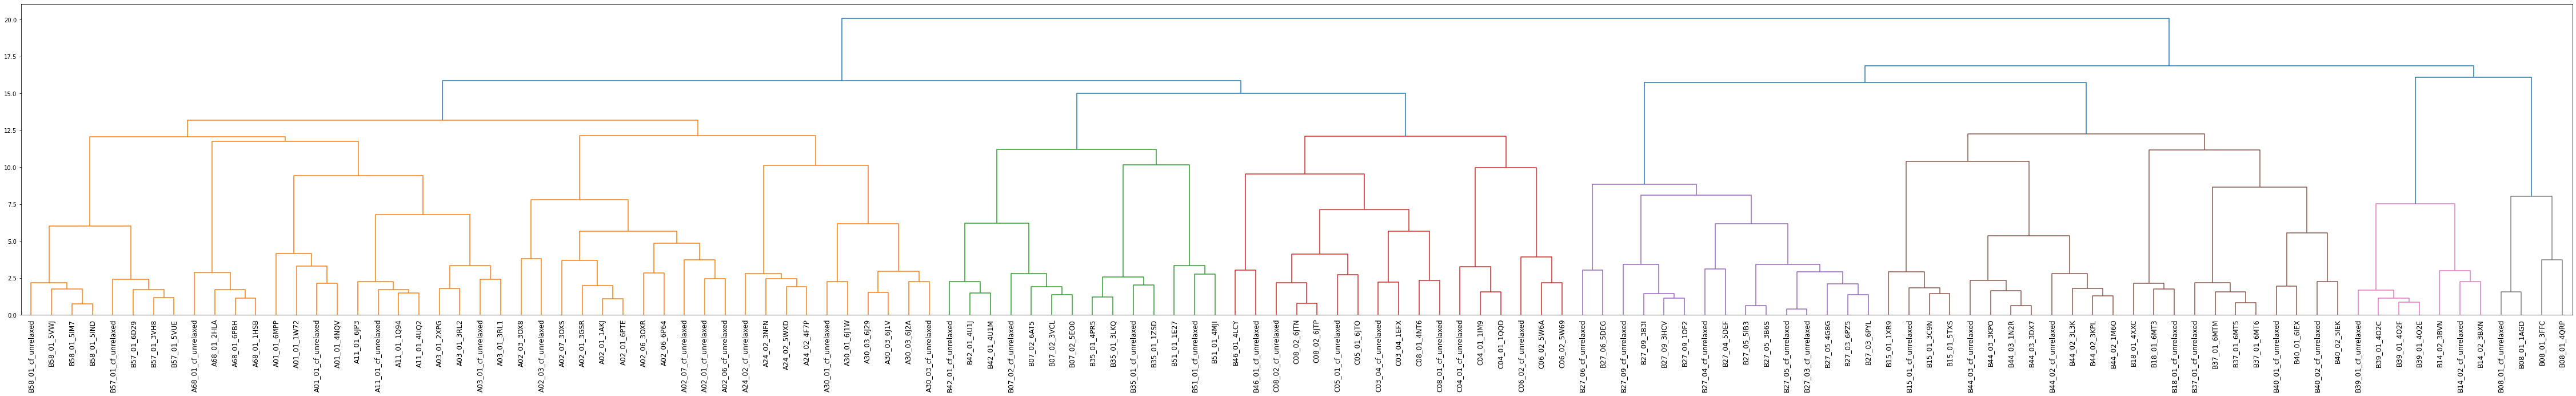

In [20]:
Mat = CGCalcMat("../Figures/Figure2_clustering_cr_hm/CG_DAT", "../Figures/Figure2_clustering_cr_hm/cf_unrelaxed.list", sigma=0.1, w=4)
_ = hierarchical_cluster(Mat, N=None, L='complete', threshold=1, plot_dendro=True, outtree="Fig2_cf_unrelaxed.newick")

#### rosetta models

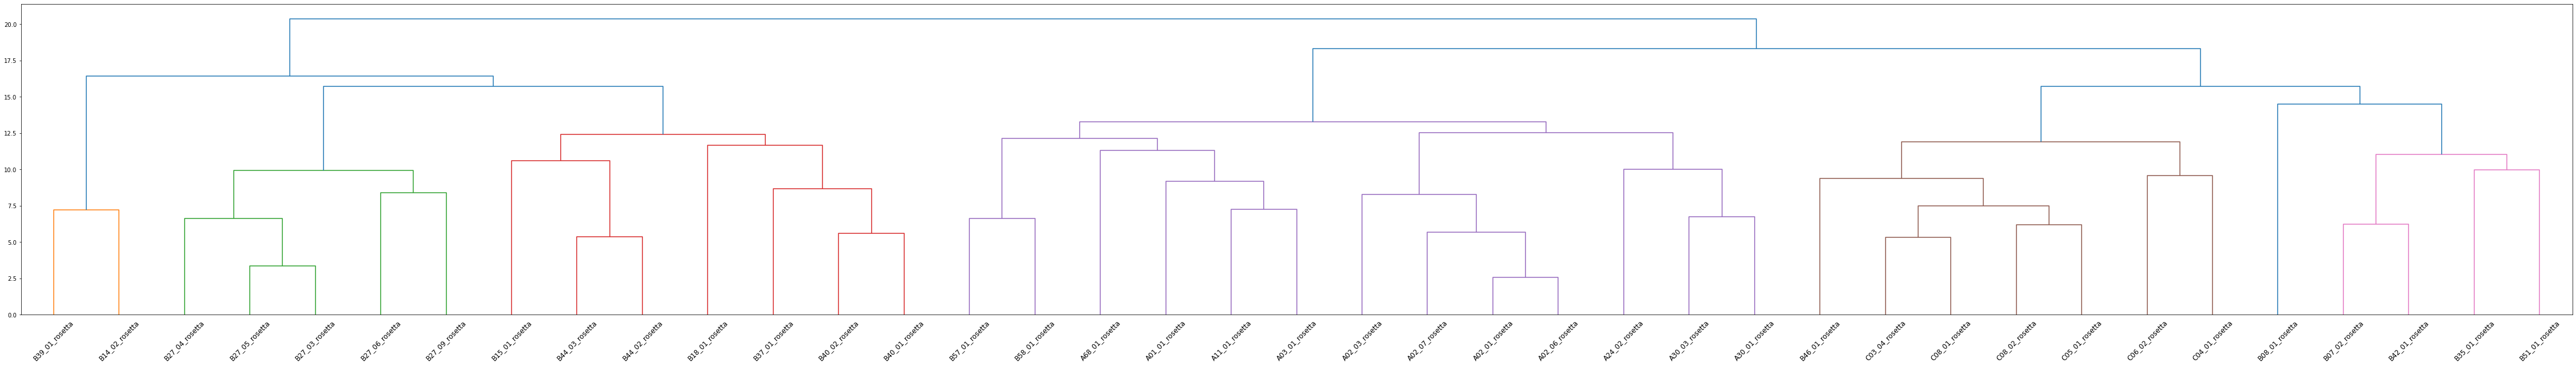

In [21]:
Mat = CGCalcMat("../Figures/Figure2_clustering_cr_hm/CG_DAT", "../Figures/Figure2_clustering_cr_hm/rosetta_only.list", sigma=0.1, w=4)
_ = hierarchical_cluster(Mat, N=None, L='complete', threshold=1, plot_dendro=True, outtree="Fig2_rosetta_only.newick")

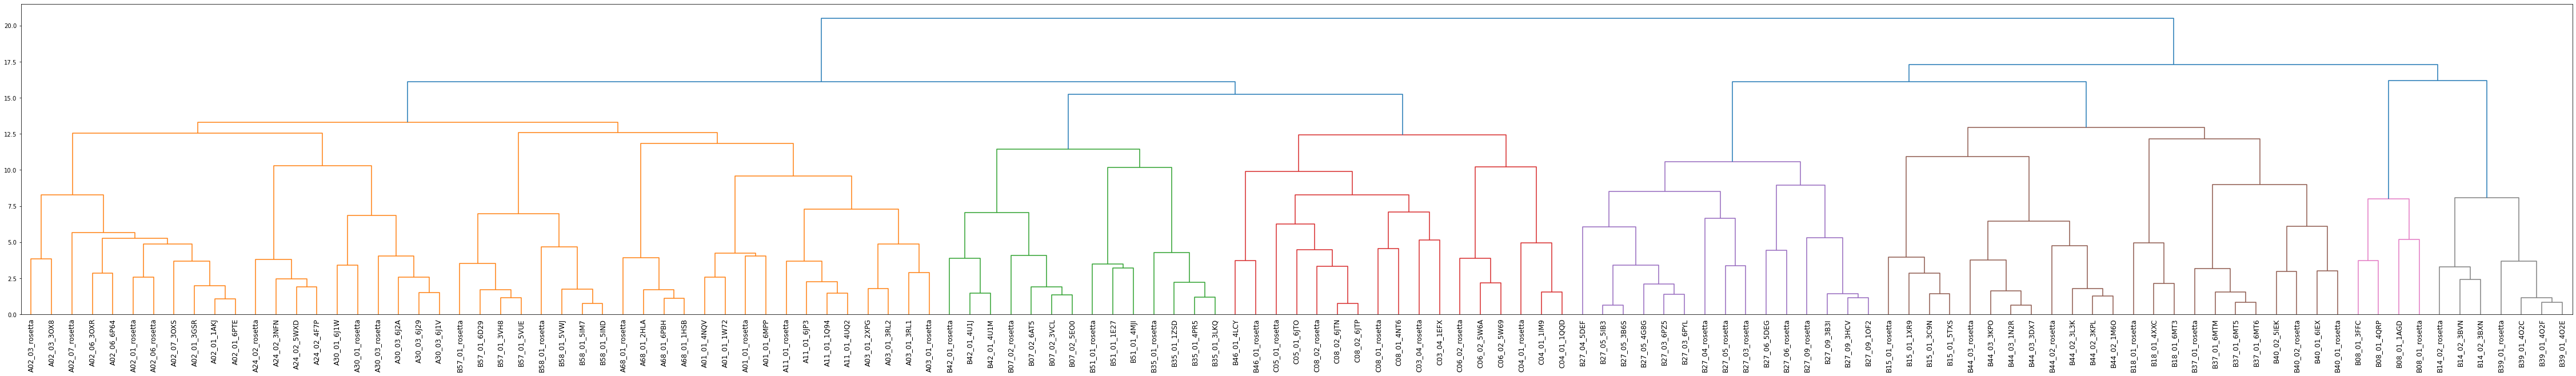

In [22]:
Mat = CGCalcMat("../Figures/Figure2_clustering_cr_hm/CG_DAT", "../Figures/Figure2_clustering_cr_hm/rosetta.list", sigma=0.1, w=4)
_ = hierarchical_cluster(Mat, N=None, L='complete', threshold=1, plot_dendro=True, outtree="Fig2_rosetta.newick")

In [23]:
import matplotlib.cm as cm
import open3d as o3d
def Show_PointCloud(DATDir):
    pointcloudlist = []
    cmap = cm.ScalarMappable(cmap="coolwarm")
    for InDAT in glob.glob(f"{DATDir}/*.csv"):
        df = pd.read_csv(InDAT)
        P1 = o3d.geometry.PointCloud()
        coord = df[['X','Y','Z']].to_numpy()
        weight = df['Weight'].to_numpy()

        color1 = cmap.to_rgba(weight)[:,0:3]
        P1.points = o3d.utility.Vector3dVector(coord)
        P1.colors = o3d.utility.Vector3dVector(color1)
        pointcloudlist.append(P1)

    o3d.visualization.draw_geometries(pointcloudlist)
    return

Show_PointCloud("../HLA1_models/CF_relaxed/CG_DAT")

: 